# Notebook for MIDAS NLP Workshop

First install the necessary packages with the following commands:

    pip install pmaw
    pip install spacy
    python -m spacy download en_core_web_lg
    pip install scikit-learn
    pip install wordcloud
    conda install matplotlib
    pip install gensim
    pip install pyldavis
    pip install transformers

## Download some data

In [1]:
from collections import Counter
import datetime

import matplotlib.pyplot as plt

from pmaw import PushshiftAPI
api = PushshiftAPI()

In [2]:
results = api.search_submissions(subreddit="uofm", limit=10000)

Not all PushShift shards are active. Query results may be incomplete.


In [3]:
posts = [p for p in results]

In [4]:
import pickle
with open("uofm.pkl", "wb") as fout:
    pickle.dump(posts, fout)

In [5]:
len(posts)

10000

In [6]:
def utc_to_local(utc_dt):
    return utc_dt.replace(tzinfo=datetime.timezone.utc).astimezone(tz=None)

In [7]:
data = [{
    'timestamp': utc_to_local(datetime.datetime.utcfromtimestamp(p['created_utc'])),
    'text': p['title'] + (' ' + p['selftext'] if 'selftext' in p else '')
} for p in posts]

In [8]:
data[0]

{'timestamp': datetime.datetime(2022, 1, 28, 0, 8, 23, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'EST')),
 'text': 'transfer from central michigan lol hey guys, i’m a freshman at central michigan university. i’m double majoring in history (BA) and philosophy (BA). cmich doesn’t really have shit, and the only reason i’m going here is because they have me a full ride. i have some really cool profs but a couple of them have told me that i should think about going somewhere else to pursue more specific interests. i’m really into ancient history/classics, and i see that umich offers all of these as majors/minors. i also want to go to grad school and get my phd after undergrad in the same field. umich honestly really appeals to me, and i know i have the grades/letters of rec/writing samples to probably apply. is it a bad idea or does it look shitty to transfer from one four year uni to another? has anyone else done this?'}

# When are these posts?

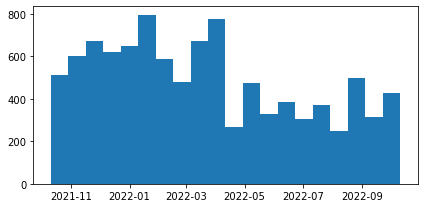

In [9]:
plt.figure(figsize=(6,3))
plt.hist([post['timestamp'] for post in data], bins=20)
plt.tight_layout()
plt.show()

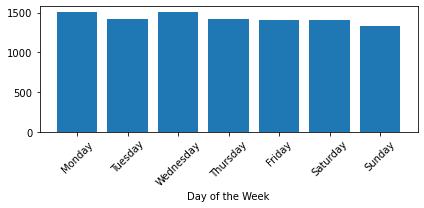

In [10]:
plt.figure(figsize=(6,3))
count = Counter([post['timestamp'].weekday() for post in data])
plt.bar(range(7), [count[wd] for wd in range(7)])
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.xlabel("Day of the Week")
plt.tight_layout()
plt.show()

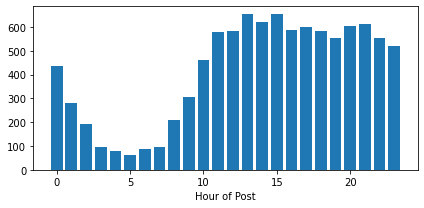

In [11]:
plt.figure(figsize=(6,3))
count = Counter([post['timestamp'].hour for post in data])
plt.bar(range(24), [count[wd] for wd in range(24)])
plt.xlabel("Hour of Post")
plt.tight_layout()
plt.show()

# What are people posting about?

In [12]:
import spacy
# from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load('en_core_web_lg')
# nlp.add_pipe('spacytextblob')

In [13]:
import re

In [14]:
for i in range(len(data)):
    data[i]['parse'] = nlp(re.sub(r"\s+", " ", data[i]['text']))

In [15]:
import pickle
with open("uofm.data.pkl", "wb") as fout:
    pickle.dump(data, fout)

In [16]:
with open("uofm.data.pkl", "rb") as fin:
    data = pickle.load(fin)

In [17]:
data[0]

{'timestamp': datetime.datetime(2022, 1, 28, 0, 8, 23, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'EST')),
 'text': 'transfer from central michigan lol hey guys, i’m a freshman at central michigan university. i’m double majoring in history (BA) and philosophy (BA). cmich doesn’t really have shit, and the only reason i’m going here is because they have me a full ride. i have some really cool profs but a couple of them have told me that i should think about going somewhere else to pursue more specific interests. i’m really into ancient history/classics, and i see that umich offers all of these as majors/minors. i also want to go to grad school and get my phd after undergrad in the same field. umich honestly really appeals to me, and i know i have the grades/letters of rec/writing samples to probably apply. is it a bad idea or does it look shitty to transfer from one four year uni to another? has anyone else done this?',
 'parse': transfer from central michigan l

In [18]:
all_words = [word.lemma_ for post in data for word in post['parse'] if not word.is_stop and not word.is_punct]

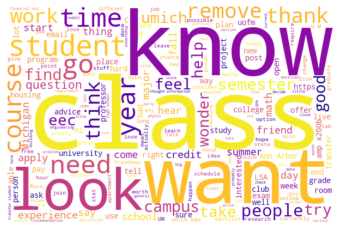

In [19]:
from wordcloud import WordCloud
cloud = WordCloud(width=600, height=400, background_color='white', colormap='plasma').generate(' '.join(all_words))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Named Entities: who/what is being mentioned

In [20]:
entities = {}
for post in data:
    for ent in post['parse'].ents:
        if ent.label_ not in entities:
            entities[ent.label_] = Counter()
        entities[ent.label_][ent.text] += 1

In [21]:
for label in entities:
    print(label)
    for word, count in entities[label].most_common(10):
        print(word, count)
    print()

GPE
Michigan 417
Ann Arbor 273
Detroit 42
US 39
michigan 27
OH 24
ann arbor 23
Ohio 18
Chicago 18
California 14

ORG
EECS 479
LSA 399
UMich 181
UM 98
MSU 93
GPA 87
CS 74
AP 70
Umich 63
WCC 62

PERSON
Ross 224
Umich 50
SUGS 28
Idk 23
Soloway 20
Mark Schlissel 18
Atlas 18
Roger 18
Munger 16
Ann Arbor 14

DATE
today 206
the summer 164
next year 159
next semester 159
tomorrow 115
this year 105
summer 85
this semester 79
this summer 78
winter 76

CARDINAL
2 311
one 290
280 282
two 258
3 253
203 227
1 225
281 221
4 172
250 122

TIME
hours 58
tonight 56
morning 19
night 18
this morning 15
last minute 15
evening 12
30 minutes 11
overnight 10
an hour 9

ORDINAL
first 421
second 120
First 32
3rd 30
third 25
2nd 23
4th 15
fourth 14
1st 13
Second 9

MONEY
20 16
15 15
30 11
25 9
500 8
1 8
200 8
50 8
thousands of dollars 7
100 7

PRODUCT
CS 33
Canvas 17
MCAT 15
BA 5
Math 217 5
Math 215 5
Math 116 4
Twitter 4
F-1 4
Chrome 4

WORK_OF_ART
PhD 36
Atlas 26
Photoshop 3
Math 201X 2
Winter 2
Applied Machine

## Most frequent words across time

In [22]:
Counter(all_words).most_common(20)

[('class', 2992),
 ('student', 2264),
 ('know', 2227),
 ('like', 2121),
 ('want', 1732),
 ('take', 1699),
 ('look', 1556),
 ('year', 1469),
 ('semester', 1421),
 ('course', 1368),
 ('eec', 1326),
 ('time', 1326),
 ('thank', 1247),
 ('get', 1226),
 ('go', 1181),
 ('people', 1162),
 ('campus', 1152),
 ('need', 1110),
 ('find', 1101),
 ('good', 1089)]

In [23]:
top_words = set(word for word, count in Counter(all_words).most_common(5))

In [24]:
counters = {}

for post in data:
    ts = post['timestamp']
    
    key = (ts.year, ts.month, ts.day)
    if key not in counters:
        counters[key] = Counter()
    
    this_post = set()
    
    for word in post['parse']:
        if word.lemma_.lower() in top_words:
            this_post.add(word.lemma_.lower())
    
    for word in this_post:
        counters[key][word] += 1 

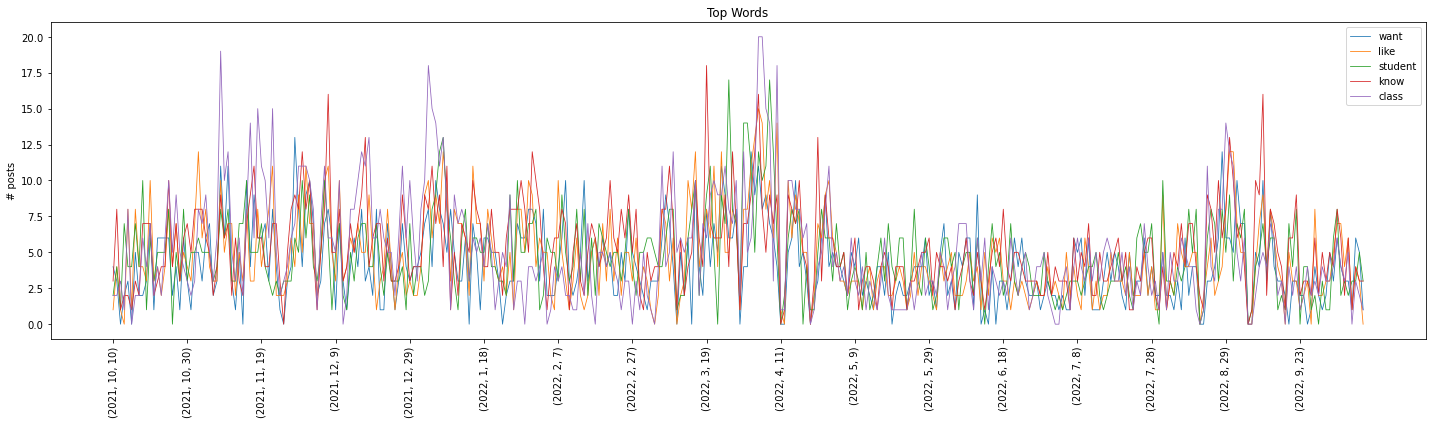

In [25]:
plt.figure(figsize=(20,6))

x = sorted(counters.keys())
for word in top_words:
    y = [counters[date][word] for date in x]
    plt.plot(range(len(x)), y, label=word, lw=0.8)

plt.legend()

plt.xticks(ticks=range(0, len(x), 20), labels=[x[i] for i in range(0, len(x), 20)], rotation=90)
plt.title("Top Words")
plt.ylabel("# posts")
plt.tight_layout()
plt.show()

# Topic Modeling

In [26]:
cleaned = [[word.lemma_.lower() for word in post['parse'] if not word.is_punct and not word.is_stop] for post in data]

In [27]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

dic = Dictionary(cleaned)
corpus = [dic.doc2bow(text) for text in cleaned]

lda = LdaModel(corpus, num_topics=10)

In [28]:
lda.save('uofm.gensim.model')

In [29]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [30]:
vis_data = gensimvis.prepare(lda, corpus, dic)
pyLDAvis.display(vis_data)

/data/winston/miniconda3/envs/workshop/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


# Sentiment Analysis

In [31]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

results = sentiment_pipeline([post['text'] for post in data], truncation=True)

/data/winston/miniconda3/envs/workshop/lib/python3.10/site-packages/transformers/image_utils.py:239: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  def resize(self, image, size, resample=PIL.Image.BILINEAR, default_to_square=True, max_size=None):
/data/winston/miniconda3/envs/workshop/lib/python3.10/site-packages/transformers/image_utils.py:396: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  def rotate(self, image, angle, resample=PIL.Image.NEAREST, expand=0, center=None, translate=None, fillcolor=None):


In [32]:
with open("results.pkl", "wb") as fout:
    pickle.dump(results, fout)

In [33]:
results

[{'label': 'NEGATIVE', 'score': 0.9799791574478149},
 {'label': 'POSITIVE', 'score': 0.9890403747558594},
 {'label': 'NEGATIVE', 'score': 0.9996191263198853},
 {'label': 'POSITIVE', 'score': 0.9975956082344055},
 {'label': 'NEGATIVE', 'score': 0.9986577033996582},
 {'label': 'NEGATIVE', 'score': 0.9984501600265503},
 {'label': 'NEGATIVE', 'score': 0.9961502552032471},
 {'label': 'NEGATIVE', 'score': 0.9991623163223267},
 {'label': 'POSITIVE', 'score': 0.9984890222549438},
 {'label': 'NEGATIVE', 'score': 0.9995280504226685},
 {'label': 'NEGATIVE', 'score': 0.9977339506149292},
 {'label': 'NEGATIVE', 'score': 0.9979504942893982},
 {'label': 'NEGATIVE', 'score': 0.9990500807762146},
 {'label': 'NEGATIVE', 'score': 0.996036946773529},
 {'label': 'POSITIVE', 'score': 0.929888904094696},
 {'label': 'NEGATIVE', 'score': 0.9958531856536865},
 {'label': 'NEGATIVE', 'score': 0.9955358505249023},
 {'label': 'POSITIVE', 'score': 0.6179600954055786},
 {'label': 'POSITIVE', 'score': 0.99326997995376

In [34]:
sentiments = {}
for post, result in zip(data, results):
    ts = post['timestamp']
    key = (ts.year, ts.month, ts.day)
    
    if key not in sentiments:
        sentiments[key] = []
    
    score = result['score'] if result['label'] == 'POSITIVE' else -result['score']
    sentiments[key].append(result['label'])

In [35]:
import numpy as np

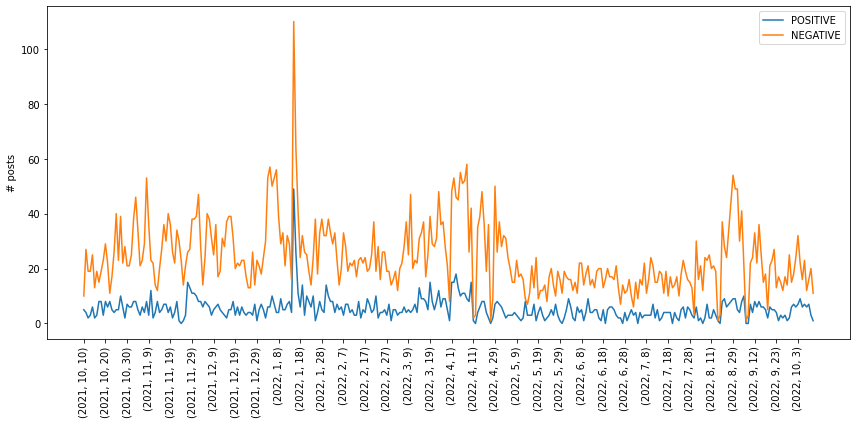

In [36]:
plt.figure(figsize=(12,6))

x = sorted(sentiments.keys())


for label in ["POSITIVE", "NEGATIVE"]:
    y = [len([x for x in sentiments[date] if x == label]) for date in x]
    plt.plot(range(len(x)), y, label=label)

plt.xticks(ticks=range(0, len(x), 10), labels=[x[i] for i in range(0, len(x), 10)], rotation=90)
plt.legend()
plt.ylabel("# posts")
plt.tight_layout()
plt.show()

# Emotions

In [37]:
import os

def read_emolex():
    emolex = {}
    for file in os.listdir('nrc-emotion-lexicon'):
        if not file.endswith(".txt"):
            continue
        emotion = file.split('.')[0]
        with open(f'nrc-emotion-lexicon/{file}') as fin:
            for line in fin:
                word, label = line.strip().split('\t')
                if label == '1':
                    if word not in emolex:
                        emolex[word] = set()
                    emolex[word].add(emotion)
    return emolex

emolex = read_emolex()

In [38]:
len(emolex)

6453

In [39]:
emotions = {}

for post in data:
    ts = post['timestamp']
    key = (ts.year, ts.month, ts.day)
    
    this_post = set()
    
    for word in post['parse']:
        word = word.text.lower()
        if word in emolex:
            for emo in emolex[word]:
                this_post.add(emo)
    
    if key not in emotions:
        emotions[key] = Counter()
    
    for emo in this_post:
        emotions[key][emo] += 1

In [40]:
emotions

{(2022,
  1,
  28): Counter({'fear': 11,
          'anticipation': 16,
          'joy': 10,
          'sadness': 14,
          'trust': 18,
          'positive': 25,
          'negative': 16,
          'disgust': 11,
          'anger': 11,
          'surprise': 7}),
 (2022,
  1,
  27): Counter({'anticipation': 22,
          'joy': 22,
          'surprise': 16,
          'trust': 29,
          'positive': 28,
          'negative': 21,
          'fear': 19,
          'disgust': 12,
          'sadness': 14,
          'anger': 13}),
 (2022,
  1,
  26): Counter({'positive': 14,
          'surprise': 5,
          'trust': 14,
          'negative': 6,
          'sadness': 5,
          'anger': 5,
          'fear': 4,
          'anticipation': 9,
          'joy': 9,
          'disgust': 3}),
 (2022,
  1,
  25): Counter({'anticipation': 17,
          'joy': 13,
          'surprise': 11,
          'disgust': 7,
          'sadness': 13,
          'trust': 21,
          'positive': 24,
          '

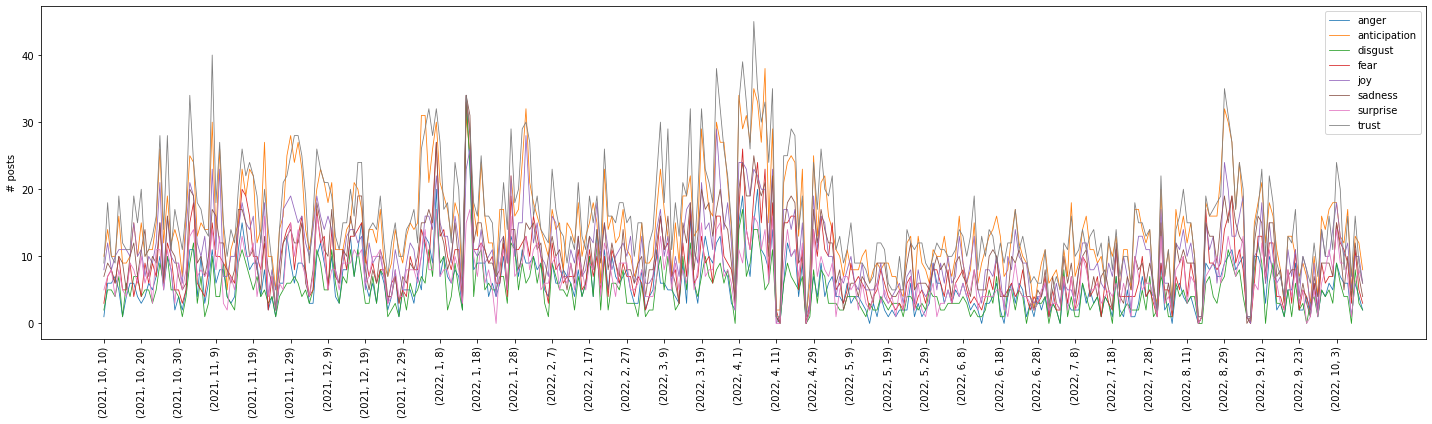

In [42]:
plt.figure(figsize=(20, 6))

EMOS = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

for emo in EMOS:
    x = sorted(emotions.keys())
    y = [emotions[x][emo] for x in x]
    plt.plot(range(len(x)), y, label=emo, lw=0.8)
    
plt.legend()
plt.xticks(ticks=range(0, len(x), 10), labels=[x[i] for i in range(0, len(x), 10)], rotation=90)
plt.ylabel("# posts")
plt.tight_layout()
plt.show()

In [43]:
[post['parse'] for post in data if post['timestamp'].year == 2022 and post['timestamp'].month == 1 and post['timestamp'].day == 15] 

[new album just dropped ,
 Calling in the big guns ,
 The devil works hard, but y’all work harder ,
 lonely m ,
 Schlisselman ,
 idk might fuck around and miss our connection to paris or something 🤪🤪🤪 ,
 The Regents posting all 118 pages of emails ,
 Mark Schlissel justifying his Pizza House order ,
 apply now! ,
 Ahead of their time ,
 Schlissel seeing all of his calzone emails leaked ,
 Sit with me ,
 In defense of Schlissel [removed],
 Lonely -Meme ,
 EECS 493 Does EECS 493 use autograder for the projects?,
 Imagine if Schlissel accidentally sent it to entirety of umich Actually. Imagine if all of us just randomly got a “You can give me a private briefing.” email from schlissy instead of the regular covid-19 friday briefings because he forgot to change his To: emails. That would have been funny I think,
 Pizza House Trending in Education lmao &amp;#x200B; https://preview.redd.it/l65vb84b2zb81.png?width=449&amp;format=png&amp;auto=webp&amp;s=8ac86610e0b27baa3cb2c9ce68149f1e445db7f9,


In [44]:
[post['parse'] for post in data if post['timestamp'].year == 2022 and post['timestamp'].month == 4 and post['timestamp'].day == 4] 

[One pixel from perfect. We stayed strong in the same spot for the whole event. THOSE WHO STAY WILL BE CHAMPIONS! ,
 I suppose to defeat them, you must become them ,
 Enrolling in Comp Sci Upper Levels Before the declaration date [removed],
 r/place MERCH POLL! Hi! We were planning on making merch (stickers and maybe shirts) with UMich, Cal, and UCLA from r/place. Do y'all prefer the version as it was at 5:54 am today with minor edits to flowers and Cal's clock (courtesy of Broadwell on discord) or u/madamebirb's version (will work with them to clean up Cal). Broadwell: https://preview.redd.it/fk4e3va8hmr81.png?width=624&amp;format=png&amp;auto=webp&amp;s=a9a588b5b0b35b7a637ebb198863f32eabf72fa5 Madamebirb: &amp;#x200B; https://preview.redd.it/p2lw97y9hmr81.png?width=1594&amp;format=png&amp;auto=webp&amp;s=412a44828eb7b2ce993e02fa880d21847d86490f [View Poll](https://www.reddit.com/poll/twkk6n),
 Fully virtual ULCS or flex techs? Does anyone know of ULCS or flex tech electives that don'